# Table of Contents
* [1.数据清洗&探索性数据分析](#chapter1)
    * [1.1 数据格式](#section_1_1)
    * [1.2 数据规模](#section_1_2)
    * [1.3 数据分布](#section_1_3)
    * [1.4 评分前几名的动漫](#section_1_4)
    * [1.5 评分数量和评分高低的关系](#section_1_5)
    * [1.6 Scrapy抓取动漫数据](#section_1_6)
    
* [2.召回层](#chapter2)
    * [2.1 Deepwalk创建物品序列](#section_2_1)
    * [2.2 Item2vec训练物品和用户Embedding](#section_2_2)
    * [2.3 保存训练好的Embedding到Redis](#section_2_3)
    * [2.4 LSH最近邻查找](#section_2_4)
* [3.排序层](#chapter3)
    * [3.1构建用户特征](#section_3_1)
    * [3.2特征工程-数值特征缩放](#section_3_2)
    * [3.3特征工程-离散特征多热编码](#section_3_3)
    * [3.4处理线上服务用户&物品特征](#section_3_4)
* [4.MLP神经网络训练](#chapter4)
    * [4.1 Tnsorflow模型训练](#section_4_1)
    * [4.2 调参](#section_4_2)
* [5.召回&排序&客户访问API后端搭建](#chapter5)

# 1.数据清洗&探索性数据分析 <a class="anchor" id="chapter1"></a>

### 1.1 数据格式<a class="anchor" id="section_1_1"></a>

* 对于anime_df, episodes预期是数值类的，但是却是object类，说明可能包含str类型的，下面对其检查类型不一致的样本,发现episodes全部是str类型,没有空值，将其转化为int类型。rating应该要是int，但是float类型，说明有可能有None或者NaN,但是没有str类型。检查后发现，rating有230个空值，将其drop掉,再检查一下type genre的空值，发现分别有25和62个空值，aired_from和aired_to是int类，所以不需要检查空值了.
---
* 对于rating_df，全部是int类，所以没有空值，也没有其他类型的值，数据很干净，menmbers字段int,也很干净
---
* 经过下面的数据处理，genre有43种，type有6中，rating是1-10的评分， -1代表没有评分

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import csv

In [2]:
anime_df=pd.read_csv("E:/Recomendation_sys_project/archive/parsed_anime.csv",index_col='anime_id')
rating_df=pd.read_csv("E:/Recomendation_sys_project/archive/rating.csv")

In [3]:
anime_df.dtypes

name               object
genre              object
type               object
episodes           object
rating            float64
members             int64
japanese_title     object
aired              object
image_url          object
aired_from          int64
aired_to            int64
dtype: object

In [4]:
rating_df.dtypes

user_id     int64
anime_id    int64
rating      int64
dtype: object

#### 处理数据的空值，重复值和其他类型的值

In [5]:
#检查空值
anime_df[anime_df['episodes'].isna()==True]

,name,genre,type,episodes,rating,members,japanese_title,aired,image_url,aired_from,aired_to
anime_id,,,,,,,,,,,


In [6]:
#检查出那些非数值类的str，并用NaN填补，然后dropna就可以
anime_df['episodes']=pd.to_numeric(anime_df['episodes'],errors='coerce')
#之后来写查看那些非数值类的episodes的代码，留一个坑！

In [7]:
anime_df[anime_df['episodes'].isna()==True].shape[0]

340

In [8]:
anime_df[anime_df['rating'].isna()==True].shape[0]

230

In [9]:
anime_df[anime_df['genre'].isna()==True].shape[0]

62

In [10]:
len(anime_df[anime_df['type'].isna()==True])

25

In [11]:
#删空值，只要某一行有就删除
anime_df=anime_df.dropna(subset=['episodes','rating','genre','type'])
anime_df['episodes']=anime_df['episodes'].astype(int)
anime_df['rating']=anime_df['rating'].astype(int)
anime_df.dtypes

name              object
genre             object
type              object
episodes           int32
rating             int32
members            int64
japanese_title    object
aired             object
image_url         object
aired_from         int64
aired_to           int64
dtype: object

#### 看看数据的枚举有哪些

In [ ]:
anime_df['genre'].unique()#发现是出现多个，需要处理一下

In [ ]:
#有43中genres
genre_list=[gen.split(',') for gen in anime_df['genre']]
genre=set([g.strip() for gen in genre_list for g in gen])
len(genre)

In [ ]:
print(anime_df['type'].unique())
print(anime_df['type'].nunique())

In [ ]:
print(rating_df['rating'].unique())
print(rating_df['rating'].nunique())

### 1.2 数据规模 <a class="anchor" id="section_1_2"></a>

在这个数据集中，有7万多的用户，有1万多部动漫，对于模型来说是一个比较好的数量级。有近8百多万评论，会对之后模型的选取有一些挑战

In [12]:
rating_df.shape[0]

7813737

In [13]:
unique_anime_count=rating_df['anime_id'].nunique()
unique_user_count=rating_df['user_id'].nunique()

In [14]:
unique_anime_count

11200

In [15]:
unique_user_count

73515

### 1.3 数据分布 <a class="anchor" id="section_1_3"></a>

#### 探索连续性数值的分布，为之后数值归一化做准备

* **Episodes:** 数据没有明显的边界，方差比较大，存在一些离群值 75%的动漫的集数是在12集一下。所以数据不适合用归一化，而是用标准化来处理
* **Anime Rating** 数据分布有明显边界且比较均匀，所以对其做归一化和标准化处理都可以。
* **member** 数据没有明显边界，所以处理方式和episode一样
* 大部分动漫的被评价的次数分布在2500次以下，有少数的分布在2500次以上
* 动漫被评价次数和评分高低之间没有一个特别明显的关系。所以评价次数不能代表动漫的质量高低，只能代表热门程度。
* genre和type的分布来看，动漫genre和type分布还是比较多样化，数量没有全部集中在3-4中的genre中。这样之后用户的genre特征的构建是会具有区分度的。
* 评分排名前20的动漫，Movie种类是最多的
* TV类型的集数比较多，其他几类的差别不大。
---
**总结** 对于动漫特征的刻画，动漫的genre,type,episodes，rating，members.对于用户特征的刻画，就是用户对动漫评分的均分，喜欢的genre, type, 还有episodes的均值。

count    11830.000000
mean        12.486729
std         47.097131
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       1818.000000
Name: episodes, dtype: float64

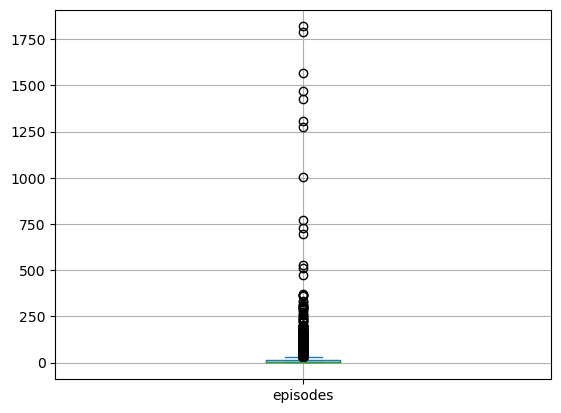

In [16]:
anime_df['episodes'].plot.box(grid=True)
anime_df['episodes'].describe()

count    11830.000000
mean         6.006932
std          1.054658
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         10.000000
Name: rating, dtype: float64

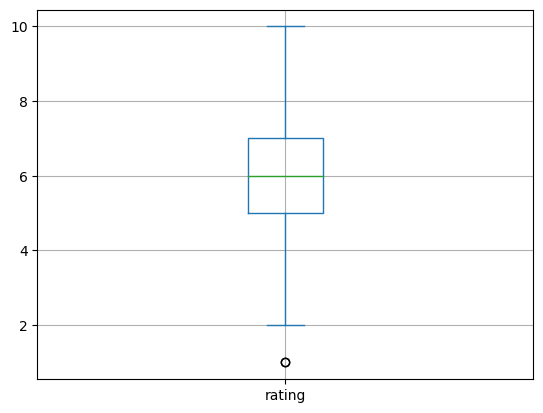

In [17]:
anime_df['rating'].plot(kind='box',grid=True)
anime_df['rating'].describe()

count    1.183000e+04
mean     1.851100e+04
std      5.537144e+04
min      1.200000e+01
25%      2.322500e+02
50%      1.589500e+03
75%      9.832000e+03
max      1.013917e+06
Name: members, dtype: float64

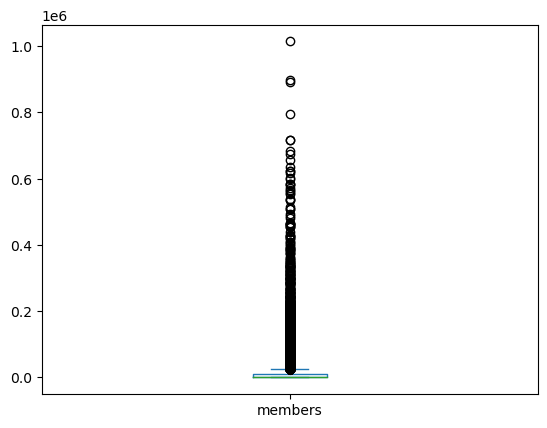

In [18]:
anime_df['members'].plot(kind='box')
anime_df['members'].describe()

In [19]:
uniq_ratings=rating_df['rating'].nunique()
uniq_ratings

11

In [20]:
rating_df['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

<AxesSubplot:ylabel='Frequency'>

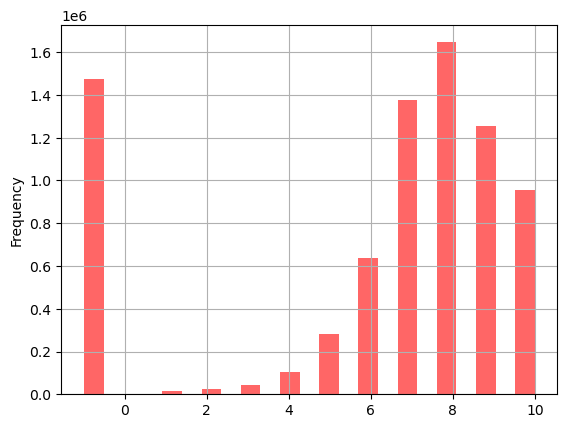

In [21]:
rating_df['rating'].plot.hist(bins=2*uniq_ratings+1,alpha=0.6,color='red',grid=True)

In [22]:
valid_rating=rating_df[rating_df['rating']>-1]

In [23]:
valid_rating.groupby('anime_id').count().describe()#一部动漫平均有638个评分，最少的是一部动漫有1个评分，最多的有34226个评分

,user_id,rating
count,9927.000000,9927.000000
mean,638.384305,638.384305
std,1795.865541,1795.865541
min,1.000000,1.000000
25%,9.000000,9.000000
50%,57.000000,57.000000
75%,395.000000,395.000000
max,34226.000000,34226.000000


<AxesSubplot:ylabel='Frequency'>

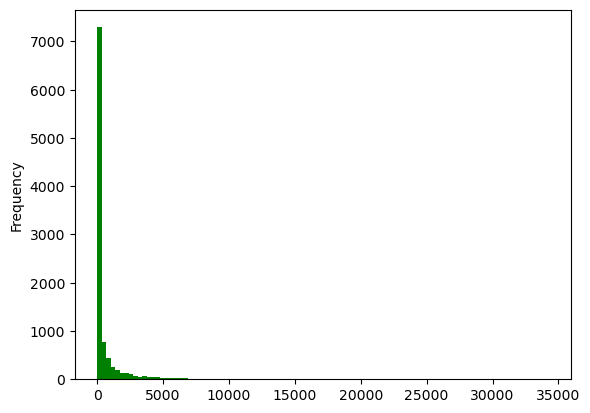

In [24]:
valid_rating.groupby('anime_id')['rating'].count().plot.hist(bins=100,grid=False,color='green')
#x轴电影评分数量区间划分， y轴，处在这个评分数量区间的电影的数量

#### 用户评分分布

In [25]:
valid_rating.groupby("user_id").count().describe()

,anime_id,rating
count,69600.000000,69600.000000
mean,91.052313,91.052313
std,135.764253,135.764253
min,1.000000,1.000000
25%,13.000000,13.000000
50%,45.000000,45.000000
75%,114.000000,114.000000
max,3747.000000,3747.000000


<AxesSubplot:ylabel='Frequency'>

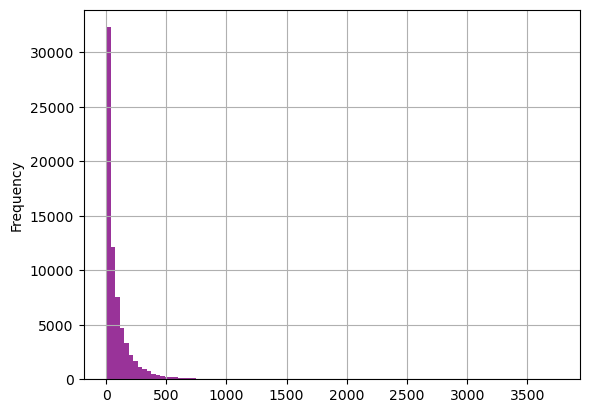

In [26]:
valid_rating.groupby("user_id")["rating"].count().plot.hist(bins=100,grid=True,alpha=0.8,color='purple')

#### 动漫类型分布

In [27]:
genres={} 

In [28]:
for (index, row) in anime_df.iterrows():
        genre_anime=[g.strip() for g in row['genre']] 
        for genre in genre_anime:
            if genre not in genres:
                genres[genre]=0
            genres[genre]+=1
print(genres)

{'D': 2497, 'r': 12186, 'a': 18507, 'm': 9143, ',': 23371, '': 26550, 'R': 1436, 'o': 19086, 'n': 15835, 'c': 14120, 'e': 22100, 'S': 9760, 'h': 5402, 'l': 5615, 'u': 8114, 'p': 2441, 't': 12317, 'A': 5415, 'i': 18441, 'd': 8723, 'v': 2293, 'F': 4247, 's': 7291, 'y': 8704, 'M': 3656, 'g': 968, 'C': 4554, 'H': 2558, 'P': 1262, '-': 2028, 'T': 86, 'w': 445, 'f': 2360, 'L': 1180, 'V': 100, 'j': 641, 'E': 627, 'J': 52, 'G': 170, 'K': 1550, 'Y': 78}


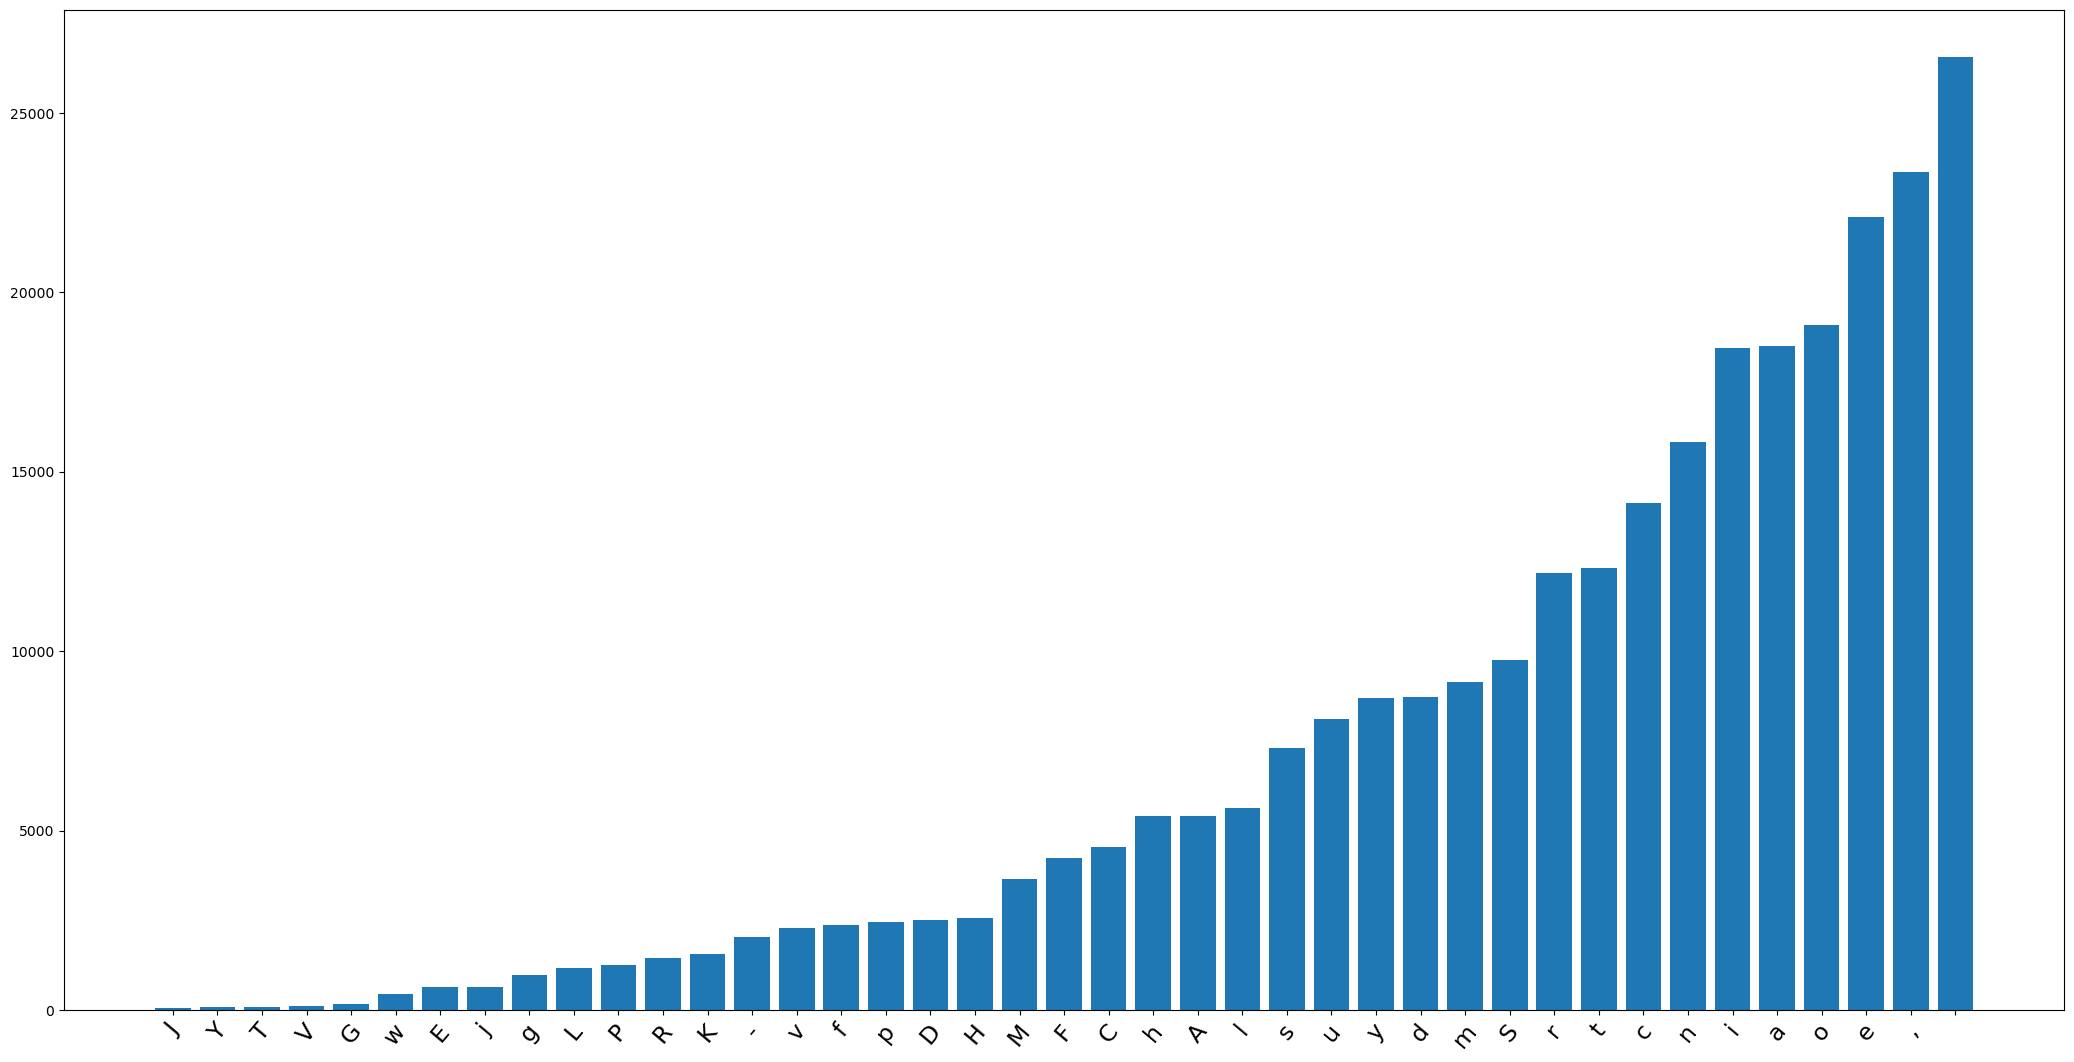

In [29]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_axes([0,0,1,1])
tuples=sorted(genres.items(),key=lambda x:x[1])
labels=[t[0] for t in tuples]
values=[t[1] for t in tuples]
ax.bar(labels,values)
plt.xticks(rotation=50,fontsize=17)
plt.show()

In [30]:
type_anime={}

In [31]:
for (index, row) in anime_df.iterrows():        
    if row['type'] not in type_anime:
        type_anime[row['type']]=0
    type_anime[row['type']]+=1
print(type_anime)

{'Movie': 2258, 'TV': 3568, 'OVA': 3246, 'Special': 1665, 'Music': 487, 'ONA': 606}


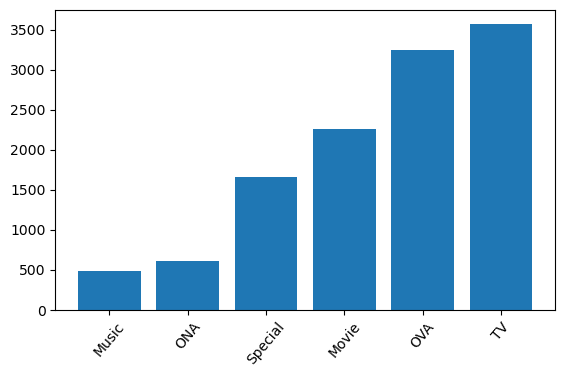

In [32]:
fig=plt.figure(figsize=(5,3))
ax=fig.add_axes([0,0,1,1])
tuples=sorted(type_anime.items(),key=lambda x:x[1])
labels=[t[0] for t in tuples]
values=[t[1] for t in tuples]
ax.bar(labels,values)
plt.xticks(rotation=50,fontsize=10)
plt.show()

<AxesSubplot:xlabel='type'>

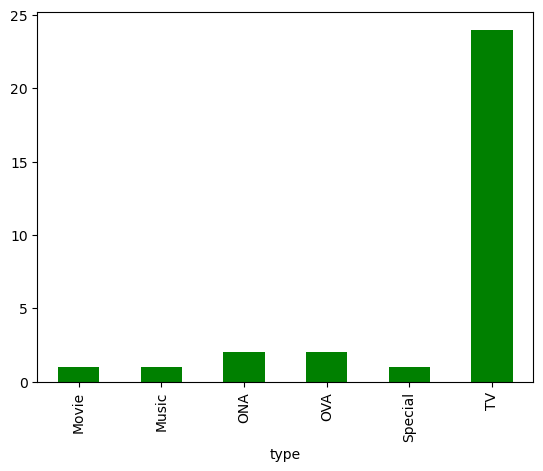

In [33]:
anime_df.groupby('type')['episodes'].median().plot(kind='bar', color='green')

### 1.4 评分前几名的动漫  <a class="anchor" id="section_1_4"></a>

In [34]:
#anime_id是index，所以不能当做列来取
top20_animes=anime_df.sort_values(by='rating',ascending=False)[['name','type','rating']].iloc[:20]
top20_animes

,name,type,rating
anime_id,,,
33662,Taka no Tsume 8: Yoshida-kun no X-Files,Movie,10
918,Gintama,TV,9
23005,Mogura no Motoro,Movie,9
26145,Okaachan Gomen ne,Movie,9
33980,Mirai ni Mukete: Bousai wo Kangaeru,Movie,9
26259,Mienu Me ni Kanjita Kumotoriyama no Asahi,OVA,9
34191,Santa-san wa Dai Isogashi,OVA,9
32627,Shaka no Shougai,Movie,9
32796,Shenmi Shijie Lixian Ji,Movie,9


In [35]:
top20_animes['type'].nunique()

3

In [36]:
top20_animes.groupby('type')['rating'].count()#受欢迎程度按照每种类型的评价数量，评价数量越多的，越受欢迎

type
Movie    10
OVA       3
TV        7
Name: rating, dtype: int64

In [37]:
top20_animes.groupby('type')['rating'].mean()#按照评分高低来衡量受欢迎程度。评分高的种类越瘦欢迎

type
Movie    9.1
OVA      9.0
TV       9.0
Name: rating, dtype: float64

### 1.5 评分数量和评分高低的关系  <a class="anchor" id="section_1_5"></a>

In [38]:
groupby_df=valid_rating.groupby('anime_id').agg({'rating':['count','mean']}).droplevel(axis=1,level=0)

In [39]:
groupby_df=valid_rating.groupby('anime_id').agg({'rating':['count','mean']}).droplevel(axis=1,level=0)

### 1.6 Scrapy抓取动漫数据  <a id="section_1_6"></a>

从 myanimelist.net爬取动漫数据，动漫详情页,海报图片url，上映时间的html标签如下\


在scrapy框架下编写spider

In [ ]:
BASE_URL = 'https://myanimelist.net/anime'

class AnimeSpider(scrapy.Spider):
    name = "anime"

    def start_requests(self):
        with open('../../data/anime/anime.csv') as csv_file:
            reader = csv.DictReader(csv_file)
            anime_ids = [row["anime_id"] for row in reader]

            with open('output.csv') as output_file:
                output_reader = csv.DictReader(output_file)
                existing_anime_ids = [row['anime_id'] for row in output_reader]

                anime_ids = [id for id in anime_ids if id not in existing_anime_ids]

                for id in anime_ids:
                    yield scrapy.Request(url=f'{BASE_URL}/{id}', callback=self.parse, meta={'anime_id': id})

网页解析

In [ ]:
def parse(self, response):
        anime_id = response.meta.get("anime_id")

        japanese_titles = response.xpath("//span[contains(text(), 'Japanese')]/../text()").getall()
        japanese_titles = [text.strip() for text in japanese_titles]
        japanese_titles = [text for text in japanese_titles if len(text) > 0][0]

        aired = response.xpath("//span[contains(text(), 'Aired')]/../text()").getall()
        aired = [text.strip() for text in aired]
        aired = [text for text in aired if len(text) > 0][0]

        image_url = response.xpath("//a[contains(@href, 'pics')]/img/@data-src").getall()[0]

        print(f"{japanese_titles}    {aired}")

        yield {
            'anime_id': anime_id,
            'japanese_title': japanese_titles,
            'aired': aired,
            'image_url': image_url
        }

# 2. 召回层 <a id="chapter2"></a>

In [51]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

### 2.1 Deepwalk创建物品序列 <a id="section_2_1"></a>

In [52]:
spark= SparkSession\
       .builder\
       .appName("concre-reall")\
       .getOrCreate()

In [53]:
rating_df=spark.read.csv('E:/Recomendation_sys_project/archive/rating.csv',header=True, inferSchema=True)
rating_df.printSchema()
rating_df=rating_df.where('rating>7.5')#评分大于7.5分的用户行为才表示推荐该电影

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [54]:
watch_seq_df=rating_df.groupby('user_id').agg(collect_list(col('anime_id').cast('string')).alias("anime_ids"))

In [55]:
watch_seq_df.show(10)

+-------+--------------------+
|user_id|           anime_ids|
+-------+--------------------+
|     31|[2581, 3784, 3785...|
|     34|[20, 30, 32, 147,...|
|     53|[101, 849, 1195, ...|
|     65|[687, 853, 1221, ...|
|     78|       [4224, 18153]|
|     85|[223, 356, 481, 5...|
|    108|[57, 61, 132, 147...|
|    137|         [121, 5114]|
|    148|[20, 81, 170, 263...|
|    155|[164, 199, 226, 3...|
+-------+--------------------+
only showing top 10 rows



这里数据是评分7分以上的电影，所以这里有一个假设，所有用户的评分行为表示用户喜欢和推荐该电影。
构建邻接矩阵就是构建graph embedding， 每一个nodes之间出现连接线表示同时出现在某一个用户的评分列表里，如果两部电影之间被多个用户评价（喜爱），那这显示了两部电影之间有某种关系（或者相似度），所以可以形成序列。 根据这个序列放到word2vec的算法里计训练出的每一个动漫的embedding, 是使用用户行为反应两个动漫之间的相似度

In [56]:
watch_seq=watch_seq_df.collect()

In [57]:
watch_seq[0]

Row(user_id=31, anime_ids=['2581', '3784', '3785', '5680', '6347', '6634', '7791', '8516', '8769', '8841', '9471', '9617', '9760', '9919', '9938', '10087', '10408', '10793', '10897', '11499', '11737', '11741', '11757', '11843', '12291', '13055', '13759', '14467', '14741', '14811', '14813', '15225', '15315', '15687', '15699', '15809', '15879', '16005', '16417', '16524'])

In [58]:
watch_seq1=[ w['anime_ids'] for w in watch_seq ]#形成的是一个二维的list

In [59]:
from collections import defaultdict
matrix=defaultdict(lambda:defaultdict(int))
matrix

defaultdict(<function __main__.<lambda>()>, {})

In [60]:
for i in range(len(watch_seq1)):
    seq=watch_seq1[i]
    for j in range(len(seq)):
        for k in range(j+1,len(seq)):
            a=seq[j]
            b=seq[k]
            if a==b:
                continue
            matrix[a][b]+=1
            matrix[b][a]+=1

#### 概率转移矩阵

 这里数据是评分7分以上的电影，所以这里有一个假设，所以用户的评分行为表示用户喜欢和推荐该电影

In [61]:
trans_probs=defaultdict(lambda: defaultdict(list))

In [62]:
trans_probs=defaultdict(lambda: defaultdict(list))
def get_transfer_probs(vs):
    neighbours=list(vs.keys())
    total_weight=__builtin__.sum(vs.values())
    probs=[weight/total_weight for weight in vs.values()]
    return neighbours,probs

In [63]:
for keys,indict in matrix.items():
    neigh,probs=get_transfer_probs(indict)
    trans_probs[keys]['neighbours']=neigh
    trans_probs[keys]["probs"]=probs

#### 随机选取入口node

In [64]:
entrence_items=list(trans_probs.keys())

In [65]:
nodes_sum={i:__builtin__.sum(matrix[i].values()) for i in entrence_items}

In [66]:
total_sum=__builtin__.sum(nodes_sum.values())

In [67]:
entren_probs=[v/total_sum for k,v in nodes_sum.items()]

#### Deepwalk

In [68]:
#1次deep walk的采样
rng= np.random.default_rng()
def one_walk(length,entrence_items,entrence_probs,transfer_probs):
    path=[]
    start_point=rng.choice(entrence_items,1,p=entrence_probs)[0]
    path.append(str(start_point))
    current_point=start_point
    for _ in range(length):
        next_point=rng.choice(transfer_probs[current_point]['neighbours'], 1, p=transfer_probs[current_point]['probs'])[0]
        path.append(str(next_point))
        current_point=next_point
    return path

In [69]:
n=10000#在实际的工作中，这个值可以更大，采样500是不够用的
deepwalk_sample=[one_walk(19,entrence_items,entren_probs,trans_probs) for _ in range(n)]

In [70]:
len(deepwalk_sample)

10000

### 2.2 Item2vec训练物品和用户Embedding <a id="section_2_2"></a>

In [71]:
from pyspark.ml.feature import Word2Vec

In [72]:
# 要用spark的word2vec，所以要将原始的list转化成spark的df
deepwalk_df=spark.createDataFrame([[row] for row in deepwalk_sample],['anime_ids'])

In [73]:
deepwalk_df.show(10)

+--------------------+
|           anime_ids|
+--------------------+
|[10357, 13601, 83...|
|[102, 437, 3470, ...|
|[10259, 553, 957,...|
|[889, 27831, 3196...|
|[71, 102, 343, 16...|
|[18893, 8630, 670...|
|[2251, 801, 138, ...|
|[5162, 3712, 1473...|
|[27833, 26349, 65...|
|[28285, 30390, 26...|
+--------------------+
only showing top 10 rows



In [74]:
item2vec=Word2Vec(vectorSize=5,maxIter=2,windowSize=15)
item2vec.setInputCol('anime_ids')
item2vec.setOutputCol('anime_ids_vec')

Word2Vec_801903d1725b

In [75]:
model=item2vec.fit(deepwalk_df)

In [76]:
rec=model.findSynonyms('12293',10)

In [77]:
#和12293 anime_id相似的动漫
rec.show()

+-----+------------------+
| word|        similarity|
+-----+------------------+
|28881|0.9943350553512573|
| 1018|0.9928957223892212|
|15359|0.9894927144050598|
|16904|  0.98778235912323|
|17074|0.9866194725036621|
| 2514|0.9834409952163696|
|23283|0.9806155562400818|
|10711|  0.97883141040802|
| 1256|0.9785686731338501|
| 9712|0.9766817092895508|
+-----+------------------+



In [78]:
anime_df=pd.read_csv('E:/Recomendation_sys_project/archive/parsed_anime.csv',sep=',')
def show_anime_info(aid,anime_df):
    info=anime_df[anime_df['anime_id']==aid].iloc[0]
    print(aid,info['name'],info['genre'],info['type'],info['episodes'],info['japanese_title'])

In [79]:
show_anime_info(12293,anime_df)

12293 Campione!: Matsurowanu Kamigami to Kamigoroshi no Maou Comedy, Ecchi, Fantasy, Harem, Magic, Romance TV 13 カンピオーネ！ ～まつろわぬ神々と神殺しの魔王～


In [80]:
for row in rec.collect():
    show_anime_info(int(row['word']),anime_df)

28881 New Initial D Movie: Legend 2 - Tousou Cars, Seinen, Sports Movie 1 新劇場版　頭文字［イニシャル］D Legend2 -闘走-
1018 Majutsushi Orphen: Revenge Adventure, Comedy, Fantasy, Magic, Shounen TV 23 魔術士オーフェンRevenge
15359 Kyousou Giga (2012) Action, Fantasy, Supernatural ONA 5 京騒戯画
16904 K: Missing Kings Action, Super Power, Supernatural Movie 1 K MISSING KINGS
17074 Monogatari Series: Second Season Comedy, Mystery, Romance, Supernatural, Vampire TV 26 〈物語〉シリーズ セカンドシーズン
2514 Detective Conan OVA 04: Conan and Kid and Crystal Mother Adventure, Mystery, Police, Shounen OVA 1 名探偵コナン: コナンとキッドとクリスタルマザー
23283 Zankyou no Terror Psychological, Thriller TV 11 残響のテロル
10711 Plastic Neesan Comedy, School ONA 12 ＋チック姉さん
1256 Saint Seiya: Jashin Eris Adventure, Sci-Fi, Shounen Movie 1 聖闘士星矢 邪神エリス
9712 Maria†Holic Alive Comedy, Parody, School, Shoujo Ai TV 12 まりあ†ほりっく あらいぶ


#### user Embedding 

计算用户的Embedding，这里不需要重新构建用户序列来构建用户\
业界常用的方法就是用用户喜欢的动漫的embedding去构用户的Embedding，用这个用户的喜欢的动漫的embedding的平均数来构建用户的embedding,背后的数学知识可以去拓展一下,这个方法在实际工作中很实际很有效

In [81]:
anime_embedding=model.getVectors().collect()

In [82]:
anime_embedding_dict={}
for row in anime_embedding:
        anime_embedding_dict[row['word']]=row['vector'].toArray()

In [83]:
@udf(returnType='array<float>')
def get_anime_embedding(col):
    user_anime_embeddings=[anime_embedding_dict[aid] if aid in anime_embedding_dict else [] for aid in col]
    #过滤掉空的list
    #__builtin__.filter(function, iterable) 会检查里面一个一个的元素，前面的function返回true就留在list里，不满足就被删除掉
    #另外的一个写法user_anime_embeddings=[e for e in user_anime_embeddings if len(e)>0]
    user_anime_embeddings=list(__builtin__.filter(lambda x:(len(x)>0),user_anime_embeddings))
    
    if not user_anime_embeddings:
        return []
    user_embedding=np.mean(user_anime_embeddings,axis=0)
    return user_embedding.tolist()

In [84]:
user_emd_df=watch_seq_df.withColumn('user_embedding',get_anime_embedding(col('anime_ids')))

In [85]:
user_emd_df.show()

+-------+--------------------+--------------------+
|user_id|           anime_ids|      user_embedding|
+-------+--------------------+--------------------+
|     31|[2581, 3784, 3785...|[-0.16534768, -0....|
|     34|[20, 30, 32, 147,...|[-0.21643454, -0....|
|     53|[101, 849, 1195, ...|[-0.16089639, -0....|
|     65|[687, 853, 1221, ...|[-0.15135884, -0....|
|     78|       [4224, 18153]|[-0.08032584, -0....|
|     85|[223, 356, 481, 5...|[-0.18453135, -0....|
|    108|[57, 61, 132, 147...|[-0.17900786, -0....|
|    137|         [121, 5114]|[-0.21894813, -0....|
|    148|[20, 81, 170, 263...|[-0.19074963, -0....|
|    155|[164, 199, 226, 3...|[-0.19674842, -0....|
|    193|            [1, 205]|[-0.18421005, -0....|
|    211|[199, 877, 1535, ...|[-0.19143154, -0....|
|    243|[223, 269, 853, 1...|[-0.1861835, -0.0...|
|    251|[813, 2001, 9756,...|[-0.13488548, -0....|
|    255|[199, 269, 431, 2...|[-0.22314133, -0....|
|    296|[1, 6, 15, 17, 20...|[-0.18772782, -0....|
|    321|[12

### 2.3 保存训练好的Embedding到Redis <a id="section_2_3"></a>

大部分情况下存储Embedding 都是用key value的方式存储

In [ ]:
from redis import Redis

In [ ]:
redis=Redis()

redis只能存储string类型的数据,将vec转成string

In [46]:
def vec2string(emb):
    return ':'.join(str(i) for i in emb)

def save_to_redis(df):
    user_emd_row=df.collect()
    emb_dict={}
    emb_dict={row.user_id: vec2string(row.user_embedding) for row in user_emd_row}
    redis.hset('recall-use-embedding',mapping=emb_dict)


In [49]:
#'name:j:nn:d'.split(':')-->['name', 'j', 'nn', 'd'] spliT之后存成一个list
def str2vec(emb):
    return [float(i)for i in emb.split(':')]

In [48]:
def read_user_emd():
    re=redis.hgetall('recall-use-embedding')
    return ({key.decode():  str2vec(value) for key,value in re.items()})

### 2.4 LSH最近邻查找 <a id="section_2_4"></a>

In [94]:
import faiss

In [95]:
emb_item={r.word: r.vector.toArray() for r in anime_embedding}
emb_item=list(__builtin__.filter(lambda x: len(x[1])>0,emb_item.items()))

In [96]:
# dict.item()得到是里面键值对形成元组
emb_item_key=[i[0] for i in emb_item]

In [89]:
emb_item_vec=[i[1] for i in emb_item]

In [90]:
index=faiss.IndexLSH(len(emb_item_vec[0]),256)

In [91]:
index.add(np.asarray(emb_item_vec,dtype=np.float32))#一次性对所有Embedding训练，之后直接取用，不用每次都训练。

In [92]:
D,I =index.search(np.asarray([emb_item_vec[99]],dtype=np.float32),10)

In [93]:
print(D)
print(I)

[[ 0. 11. 11. 12. 12. 15. 15. 15. 15. 15.]]
[[  99  528 2830 1297 1793  566 2363 3016 3052 3423]]


# 3.排序层<a id="chapter3"></a>

### 3.1构建用户特征 <a id="section_3_1"></a>

In [97]:
from pyspark.sql.types import IntegerType
anime_df=spark.read.csv('E:/Recomendation_sys_project/archive/parsed_anime.csv',header=True, inferSchema=True)
#
anime_df=anime_df\
         .withColumnRenamed("rating",'all_rating')\
         .withColumn('aired_from',col('aired_from').cast('int'))\
         .filter( col('genre').isNotNull()&
                  col('all_rating').isNotNull()&
                  col('aired_from').isNotNull()&
                  col("aired_to").isNotNull()
                )\
         .withColumn('episodes',col('episodes').cast('int'))

In [98]:
anime_df.printSchema()

root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: integer (nullable = true)
 |-- all_rating: double (nullable = true)
 |-- members: integer (nullable = true)
 |-- japanese_title: string (nullable = true)
 |-- aired: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- aired_from: integer (nullable = true)
 |-- aired_to: integer (nullable = true)



In [99]:
#rating_df的ratinng列没有空值
rating_df_rank=spark.read.csv('E:/Recomendation_sys_project/archive/rating.csv',header=True, inferSchema=True)
rating_df_rank=rating_df.where('rating>0')#评分大于7.5分的用户行为才表示推荐该电影
rating_df_rank.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [100]:
like_threshold=7.5
merged_df=rating_df_rank.join(
          anime_df.select('anime_id','name','genre','type','episodes','all_rating','members','aired_from','aired_to'),
          on='anime_id',how='left'
    
).withColumn(
    'label',
    when(col('rating')>like_threshold,1).otherwise(0)
             
    ).filter(col('all_rating').isNotNull()|col('genre').isNotNull()| col('members').isNotNull())

In [101]:
merged_df.count()

3855820

### 3.2特征工程-数值特征缩放 <a id="section_3_2"></a>

#### numberic features: Standardization

In [102]:
from pyspark.ml.feature import MinMaxScaler,VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import pyspark.sql.types as types 

In [103]:
@udf(types.FloatType())
def extract_float(s):
    NUMBER_PRECISION=2
    r=__builtin__.round(s[0],NUMBER_PRECISION)
    return float(r)

In [104]:
class numbericScaler():
    def __init__(self, cols):
        self.cols=cols
        self.pipelines=self.__numeric_col(cols)
        
    def __numeric_col(self,cols):
        pipelines=[self.__numeric_single_col(col) for col in self.cols]
        Pipeline(stages=pipelines)
        return Pipeline(stages=pipelines)
        
    
    def __numeric_single_col(self, col):
        vec=VectorAssembler(inputCols=[col], outputCol=f'{col}_vec',handleInvalid='keep')
        scaler=StandardScaler(inputCol=f'{col}_vec', outputCol=f'{col}_Standardization',withMean=True,withStd=True)
        pipeline=Pipeline(stages=[vec,scaler])
        return pipeline
    
    def fit(self,df):
        self.model=self.pipelines.fit(df)#self.model是一个实例化变量，可以被在numericScaler类的其他的方法中使用
        
    def transform(self,df):
        result=self.model.transform(df)
        #drop all intermedia cols and covert output to float
        for col in self.cols: 
            result=result\
               .drop(f'{col}_vec')\
               .withColumn(f'{col}_Standardization',extract_float(F.col(f'{col}_Standardization')))
        return result
        

### 3.3特征工程-离散特征多热编码 <a id="section_3_3"></a>


#### categorical data - multi hot

In [105]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import SparseVector

In [106]:
def encode_genres_col(index_mapping_broadcasted):
    @udf(returnType='array<int>')
    def encode_genres_col(colvalue,max_genre_index):
        if  colvalue is None:
            colvalue=[]
        genre_index=[index_mapping_broadcasted.value.get(i) for i in colvalue]
        genre_index=list(set(genre_index))
        
        fill=np.ones(len(genre_index),dtype=np.int32)
        sorted_index=np.sort(genre_index)
        multi_hot=SparseVector(max_genre_index+1,sorted_index,fill)
        return multi_hot.toArray().astype(np.int32).tolist()
    
    return encode_genres_col    
    

In [107]:
class CategoricalEncoder:
    def __init__(self,colname):
        self.colname=colname       
    
    def fit(self,df):

        explode_df=df\
                   .withColumn(f'{self.colname}_item',explode(col(self.colname)))
        
        col_string=StringIndexer(inputCol=f'{self.colname}_item',outputCol=f'{self.colname}_index')
        model=col_string.fit(explode_df)
        labels_df=spark.createDataFrame(
                  [{f'{self.colname}_item': g} for g in model.labels]
              )
        mapping_df=model.transform(labels_df).collect()
        mapping_dict={row[f'{self.colname}_item'] : int(row[f'{self.colname}_index']) for row in mapping_df}
        self.max_index=__builtin__.max(mapping_dict.values())
        broadcast=spark.sparkContext.broadcast(mapping_dict)
        self.encode_fn=encode_genres_col(broadcast)
    
    def transform(self,df):
            result=df.withColumn(f'{self.colname}_multihot',
                           self.encode_fn(col(self.colname),lit(self.max_index)))
            
            return result
    

#### 构建DNN训练数据

In [108]:
from pyspark.sql import Window
from collections import Counter

In [109]:
windowSpec=Window\
       .partitionBy('user_id')\
       .orderBy('aired_from')\
       .rowsBetween(-100,-1)

In [110]:
likeAnimeCol=lambda colname: when(col('label')==1,col(colname)).otherwise(None)


@udf(returnType='array<string>')
def genre_to_list(gen_str):
    if gen_str is None:
        return []
    
    gens=gen_str.split(',')
    return [g.strip() for g in gens]

@udf(returnType='array<string>')
def type_to_list(type_str):
    if type_str is None:
        return []
    return [type_str.strip()]

    
#chose first 5 like genre

@udf(returnType='array<string>')
def most_liked_genre(collect_str):
    #collect_str is list like ['action,drama,sci-fi','drama,adventure']  
    genre=[i.split(',') for  i in collect_str]
    genre_list=[ge.strip() for i in genre for ge in i]
    genre_dict=dict(Counter(genre_list))
    genre_list_sorted=sorted(genre_dict.items(),key=lambda x:x[1],reverse=True)
    #select first 5 genre as users' most like
    most_like_genres=[key for key,value in genre_list_sorted[:5]]
    return most_like_genres

@udf(returnType='array<string>')
def most_liked_type(collect_type_list):
    #['move','music']
    collect_type=[c.strip() for c in collect_type_list]
    type_dict=dict(Counter(collect_type))
    #[('movie',5),('music',3)]
    sorted_type_list=sorted(type_dict.items(),key=lambda x: x[1],reverse=True)#x[1]就是以值来排序,拍完序之后返回的是一个list，不是dict
    #sorted_type_dict[:2]这样索引的切分只能用于list，tuple，string,不能用于dict
    if len(sorted_type_list)==0:
        return None
    elif len(sorted_type_list)<2:
        return [k for k,v in sorted_type_list]
    
    most_liked_type=[k for k,v in sorted_type_list[:2]]
    return most_liked_type

In [111]:
feat_df=merged_df\
         .withColumn('genres',genre_to_list(col('genre')))\
         .withColumn('types',type_to_list(col('type')))\
         .withColumn('user_rating_cnt',count(lit(1)).over(windowSpec))\
         .withColumn('user_rating_ave',mean(col('rating')).over(windowSpec))\
         .withColumn('user_rating_ave',F.round(col('user_rating_ave'),2))\
         .withColumn('user_rating_std',stddev(col('rating')).over(windowSpec))\
         .withColumn('user_rating_std',F.round(col('user_rating_std'),2))\
         .withColumn('user_aired_from_ave', mean(likeAnimeCol('aired_from')).over(windowSpec))\
         .withColumn('user_aired_from_ave',F.round(col('user_aired_from_ave'),0))\
         .withColumn('user_aired_to_ave',mean(likeAnimeCol('aired_to')).over(windowSpec))\
         .withColumn('user_aired_to_ave',F.round(col('user_aired_to_ave'),0))\
         .withColumn('user_liked_genres',most_liked_genre(collect_list(likeAnimeCol('genre')).over(windowSpec)))\
         .withColumn('user_liked_type',most_liked_type(collect_list(likeAnimeCol('type')).over(windowSpec)))\
         .withColumn('user_episodes_ave',mean(likeAnimeCol('episodes')).over(windowSpec))\
         .withColumn('user_episodes_ave',F.round(col('user_episodes_ave'),0))

In [112]:
feat_df.show(15,vertical=True)

-RECORD 0-----------------------------------
 anime_id            | 2581                 
 user_id             | 31                   
 rating              | 9                    
 name                | Mobile Suit Gunda... 
 genre               | Action, Drama, Me... 
 type                | TV                   
 episodes            | 25                   
 all_rating          | 8.24                 
 members             | 120351               
 aired_from          | 1191600000           
 aired_to            | 1206720000           
 label               | 1                    
 genres              | [Action, Drama, M... 
 types               | [TV]                 
 user_rating_cnt     | 0                    
 user_rating_ave     | NULL                 
 user_rating_std     | NULL                 
 user_aired_from_ave | NULL                 
 user_aired_to_ave   | NULL                 
 user_liked_genres   | []                   
 user_liked_type     | NULL                 
 user_epis

In [113]:
feat_df=feat_df\
.filter(col('user_rating_ave').isNotNull())\
.filter(col('user_rating_std')!=0.0)\
.filter(col('user_rating_std').isNotNull())\
.filter(col('user_aired_from_ave').isNotNull())\
.filter(col('user_aired_to_ave').isNotNull())\
.filter(col('user_episodes_ave').isNotNull())\
.filter(col('episodes').isNotNull())

In [114]:
feat_df.count()

3617190

1.Trian item numeric 

In [115]:
item_numeric_cols=[
    'all_rating',
    'members',
    'aired_from',
    'aired_to',
    'episodes'
]
item_numeric_scaler=numbericScaler(item_numeric_cols)

In [116]:
item_numeric_scaler.fit(feat_df)

2.Train user numeric

In [117]:
user_numeric_cols=[
    'user_rating_ave',
    'user_rating_std',
    'user_aired_from_ave',
    'user_aired_to_ave',
    'user_episodes_ave'
    
]
user_numeric_scaler=numbericScaler(user_numeric_cols)

In [118]:
user_numeric_scaler.fit(feat_df)

3.Train item categorical 

In [119]:
item_categorical_encoder_g=CategoricalEncoder('genres')
item_categorical_encoder_g.fit(feat_df)

item_categorical_encoder_t=CategoricalEncoder('types')
item_categorical_encoder_t.fit(feat_df)

4.Train user cattegorical

In [120]:
user_categorical_encoder_g=CategoricalEncoder('user_liked_genres')
user_categorical_encoder_g.fit(feat_df)

user_categorical_encoder_t=CategoricalEncoder('user_liked_type')
user_categorical_encoder_t.fit(feat_df)

#### Transform

1.user & item numeric

In [121]:
transformed_df=item_numeric_scaler.transform(feat_df)
transformed_df=user_numeric_scaler.transform(transformed_df)

2.user & item categorical

In [ ]:
transformed_df=item_categorical_encoder_g.transform(transformed_df)
transformed_df=item_categorical_encoder_t.transform(transformed_df)
transformed_df=user_categorical_encoder_g.transform(transformed_df)
transformed_df=user_categorical_encoder_t.transform(transformed_df)

In [123]:
transformed_df.show(10,vertical=True)

-RECORD 0---------------------------------------------------
 anime_id                            | 6347                 
 user_id                             | 31                   
 rating                              | 9                    
 name                                | Baka to Test to S... 
 genre                               | Comedy, Romance, ... 
 type                                | TV                   
 episodes                            | 13                   
 all_rating                          | 7.83                 
 members                             | 301282               
 aired_from                          | 1262793600           
 aired_to                            | 1270051200           
 label                               | 1                    
 genres                              | [Comedy, Romance,... 
 types                               | [TV]                 
 user_rating_cnt                     | 3                    
 user_rating_ave        

### 3.4处理线上服务用户&物品特征 <a id="section_3_4"></a>

对于给线上服务提供的用户和物品的特征集，对于动漫信息，没有必要把历史上用户看过的每一个动漫信息全部处理一遍，只要拿到动漫最新的数据就可以了。从模型上线那一刻开始，模型所用到的数据就是只需要最新的特征。比如一天前，一个月前，一年前动漫的特征是什么样子，线上服务是不用去关心的。

In [ ]:
anime_genre_df=anime_df\
       .withColumn('genres',genre_to_list('genre'))

anime numeric 

In [ ]:
cc=item_numeric_scaler.transform(anime_genre_df)

anime categorical

In [ ]:
item_both_transformed_df=item_categorical_encoder.transform(cc)
item_both_transformed_df.count()

In [ ]:
item_both_transformed_df.show(10,vertical=True)

把这些处理好的数据存下来，存在合适的地方，共后续的整个系统来来使用，深度学习模型训练所需要的数据，可以先将其写成CSV的文件，由于深度学习的模型训练是离线计算的，而且可以是批量的，分批的进行学习，所以并不一定要把他们存放在在线上可以轻易访问到的，比如redis这些比较热的数据库中，可以存放在一个比较冷的htfs,或者本地磁盘上

In [ ]:
w=Window.partitionBy('user_id')

In [ ]:
user_feat_df=feat_df\
            .withColumn('max_aired',max(col('aired_from')).over(w))\
            .where(col('max_aired')==col('aired_from'))\
            .drop('max_aired')
#实现以上的功能的代码还有一个写法
#w1=Window.partitionBy('user_id').orderBy(col('aired_from').desc()).
#feat_df\
      #.withColumn('row_index',row_number().over(w1))\ #在窗口排好序之后，给每一行一个index，取row index是1的都能保证取到最大值的那一行
      #.filter(col('row_index')==1)\
      #.drop('row_index')

In [ ]:
user_feat_df.select('user_id','anime_id','aired_from').show(5)

In [ ]:
user_numeric_transformed_df=user_numeric_scaler.transform(user_feat_df)

In [ ]:
user_both_transformed_df=user_categorical_encoder.transform(user_numeric_transformed_df)
user_both_transformed_df.count()

In [ ]:
user_both_transformed_df.show(10,vertical=True)

#### Save user and item features to redis，供线上系统随时来访问

In [ ]:
item_features=item_both_transformed_df.collect()

In [ ]:
item_features[1]

In [ ]:
user_features=user_both_transformed_df.collect()

In [ ]:
user_features[1]

# 4. MLP神经网络 <a id="chapter4"></a>

In [3]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("ReadParquet").getOrCreate()

#### Define features

读入数据对模型进行训练，帮助函数，把我们所要的数值或者分类特征取出来，将其转成numpy array,tensorflow支持的类型是numpy array,所以既不能是pandas dataframe也不能是python list

In [127]:
def get_item_numeric_features(df):
    numeric_features=[
        "all_rating_Standardization",
        "members_Standardization",
        "aired_from_Standardization",
        "aired_to_Standardization" ,
        "episodes_Standardization"
    ]
    return df[numeric_features].to_numpy()

def get_user_numeric_features(df):
    numeric_features=[
    'user_rating_ave_Standardization',
    'user_rating_std_Standardization',
    'user_aired_from_ave_Standardization',
    'user_aired_to_ave_Standardization',
    'user_episodes_ave_Standardization'
    ]
    return df[numeric_features].to_numpy()

In [128]:
def get_multihot_features(df,feat_name):
    
    feat_df=df[[feat_name]]
    feat_vec=feat_df.to_numpy()
    feat_vec=np.apply_along_axis(lambda v: v[0],1,feat_vec)
    return feat_vec  

In [129]:
def get_label(df):
    label=df[['label']]
    return label

In [130]:
def get_all_features(df):
    return(
        get_multihot_features(df,'genres_multihot'),
        get_multihot_features(df,'user_liked_genres_multihot'),
        get_item_numeric_features(df),
        get_user_numeric_features(df)
    )

#### Load data

In [7]:
#root是文件的绝对路径，files是文件名称
def data_files():
    filename=[]
    for root,dirs, files in os.walk('E:\Recomendation_sys_project\DNN_training_data'):
        for f in files:
            if f.endswith('.parquet'):
                filename.append(os.path.join(root,f))
    return filename
            

In [8]:
file_path=data_files()

In [9]:
for file in file_path:
    #df=pd.read_parquet(file)
    df=spark.read.parquet(file)

In [9]:
get_item_numeric_features(df)#将传入的numeric_features的四个数值特征构成一个4维的数值向量

array([[0.88, 0.27, 0.69, 0.68],
       [0.82, 0.08, 0.86, 0.87],
       [0.76, 0.37, 0.87, 0.86],
       ...,
       [0.8 , 0.33, 0.96, 0.94],
       [0.9 , 0.34, 0.96, 0.95],
       [0.98, 0.11, 0.96, 0.95]], dtype=float32)

In [ ]:
train_df=transformed_df.sample(frac=0.8,random_state=666)
test_df=transformed_df.drop(train_df.index)

In [11]:
train_x1,train_x2,train_x3,train_x4=get_all_features(train_df)

In [ ]:
len(train_x1)

In [ ]:
test_x1,test_x2,test_x3,test_x4=get_all_features(test_df)

In [12]:
train_y=get_label(train_df)
test_y=get_label(test_df)

### 4.1 模型训练 <a id="section_4_1"></a>

x1: item categorical features\
x2: user catergorical features\
x3: item numeric features\
x4: user numerica features

In [4]:
def build_model(x1_shape,x2_shape,x3_shape,x4_shape):
    x1_input=keras.layers.Input(shape=(x1_shape,))
    x2_input=keras.layers.Input(shape=(x2_shape,))
    x3_input=keras.layers.Input(shape=(x3_shape,))
    x4_input=keras.layers.Input(shape=(x4_shape,))
    #end2end  embedding 降维
    compact_x1=keras.layers.Dense(10)(x1_input)
    compact_x2=keras.layers.Dense(10)(x2_input)
    
    #输入层
    merge=keras.layers.concatenate([compact_x1,compact_x2,x3_input,x4_input])
    #隐藏层
    #first hidden layer,128个神经元
    h1=keras.layers.Dense(128,activation='relu')(merge)
    h2=keras.layers.Dense(128,activation='relu')(h1)
    #输出层
    output=keras.layers.Dense(1,activation='sigmoid')(h2)
    
    model=keras.models.Model(inputs=[x1_input,x2_input,x3_input,x4_input],outputs=output)
    return model

In [5]:
model3=build_model(43,43,5,5)

In [6]:
model3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model3.fit([train_x1,train_x2,train_x3,train_x4],train_y,batch_size=30,epochs=2,validation_split=0.2)

In [18]:
model2=build_model(43,43,5,5)

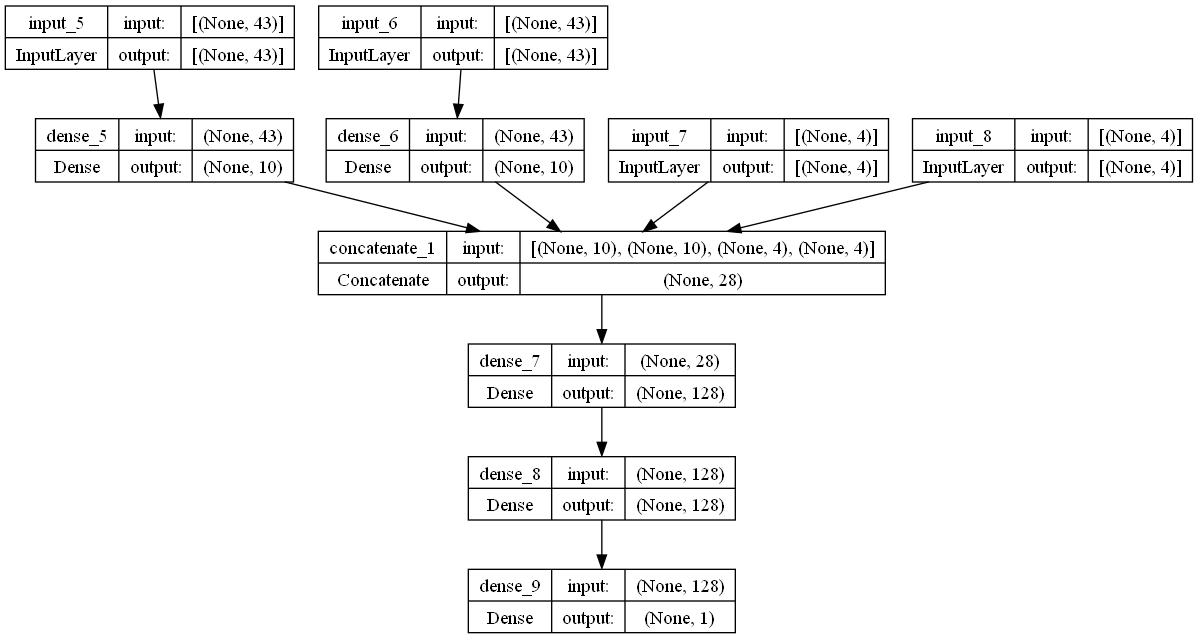

In [20]:
keras.utils.plot_model(model2,show_shapes=True)

In [21]:
model2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#batch_size训练数据分批的批次，epochs训练几轮
model2.fit([train_x1,train_x2,train_x3,train_x4],train_y,batch_size=30,epochs=2,validation_split=0.2)

Epoch 1/2
117334/117334 [==============================] - 192s 2ms/step - loss: 0.6700 - accuracy: 0.6076 - val_loss: 0.6698 - val_accuracy: 0.6077
Epoch 2/2
117334/117334 [==============================] - 201s 2ms/step - loss: 0.6699 - accuracy: 0.6076 - val_loss: 0.6698 - val_accuracy: 0.6077


#### test model (first attempt)

In [ ]:
test_loss,test_accuracy=model.evaluate([test_x1,test_x2,test_x3,test_x4],test_y)

### 4.2 模型调参与模型评估 <a id="section_4_2"></a>

老师的模型精确度达到了0.75，但是我的才0.61，可以对模型性能提升的方式有：调整模型的参数，还有认为其他可能影响到模型的feature,看看有可能相关的features,将其添加到模型里

In [10]:
from tensorboard.plugins.hparams import api as hp


In [11]:
HP_LAYERS=hp.HParam('layers',hp.IntInterval(2,3))
HP_LAYER_SIZE=hp.HParam('layer_size',hp.Discrete([64,128,256]))
HP_LEARN_RATE=hp.HParam('learning_rate',hp.Discrete([0.001,0.003,0.01]))
HParam=[
    HP_LAYERS,
    HP_LAYER_SIZE,
    HP_LEARN_RATE 
]

METRICS=[
    hp.Metric('loss',group='train',display_name='loss_train'),
    hp.Metric('loss',group='validation',display_name='loss_val')
]

In [12]:
def tuning_model(x1_shape,x2_shape,x3_shape,x4_shape,hparam):
    x1_input=keras.layers.Input(shape=(x1_shape,))
    x2_input=keras.layers.Input(shape=(x2_shape,))
    x3_input=keras.layers.Input(shape=(x3_shape,))
    x4_input=keras.layers.Input(shape=(x4_shape,))
    #end2end  embedding 降维
    compact_x1=keras.layers.Dense(10)(x1_input)
    compact_x2=keras.layers.Dense(10)(x2_input)
    
    #输入层
    merge=keras.layers.concatenate([compact_x1,compact_x2,x3_input,x4_input])
    h_pre=merge
    for _ in range(hparam[HP_LAYERS]):
        h=keras.layers.Dense(hparam[HP_LAYER_SIZE],activation='relu')(h_pre)
        h_pre=h
    
    #输出层
    output=keras.layers.Dense(1,activation='sigmoid')(h)
    
    model=keras.models.Model(inputs=[x1_input,x2_input,x3_input,x4_input],outputs=output)
     
    opt=keras.optimizers.Adam(learning_rate=hparam[HP_LEARN_RATE])
    model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
        )
    #tf.config.run_functions_eagerly(True)
    tf.data.experimental.enable_debug_mode()
    return model

In [17]:
#构建可能的超参数组合
#然后对每个模型传输这些超参数组合
def test_param(df):
    
    with tf.summary.create_file_writer('hparams').as_default():
         hp.hparams_config(hparams=HParam, metrics=METRICS)
        
    model_id=0 
    for layers in range(HP_LAYERS.domain.min_value,HP_LAYERS.domain.max_value+1):
        for size in HP_LAYER_SIZE.domain.values:
            for rate in HP_LEARN_RATE.domain.values:
                #之前创建的HParam对象(HP_LAYERS)为键
                hparam_dict={
                    HP_LAYERS:layers,
                    HP_LAYER_SIZE:size,
                    HP_LEARN_RATE:rate
                }
                run_model(hparam_dict,model_id,df)
                model_id+=1
    
                
#给定某一个超参数组合，给定模型，并且训练模型
#给每个model一个ID
def run_model(hparams,model_id,df):
    
    model_t=tuning_model(43,43,4,4,hparams)
    print(f"\nmodel id: {model_id}")
    print({p.name: hparams[p] for p in hparams})
    #
    log_filename=f'{model_id}'
    for h in hparams:
        log_filename+=f"_{h.name}_{hparams[h]}"
        
    log_dir=os.path.join('hparams',log_filename)
    tensorboard_callback=tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        update_freq=10,
        profile_batch=0 
    )
    hparams_callback=hp.KerasCallback(log_dir,hparams)
    #读取文件
    #file_path=data_files()
    #for file in file_path:
         #df=pd.read_parquet(file)

    train_df=df
    train_x1,train_x2,train_x3,train_x4=get_all_features(train_df)
    train_y=get_label(train_df)
    model_t.fit(
         [train_x1,train_x2,train_x3,train_x4],
         train_y,
         batch_size=25,
         epochs=4,
         validation_split=0.2,
         callbacks=[tensorboard_callback,hparams_callback]
    )

In [ ]:
%rm -rf hparam
test_param(df)


model id: 0
{'layers': 2, 'layer_size': 64, 'learning_rate': 0.001}
Epoch 1/4
176000/176000 [==============================] - 459s 3ms/step - loss: 0.6694 - accuracy: 0.6089 - val_loss: 0.6719 - val_accuracy: 0.6027
Epoch 2/4
176000/176000 [==============================] - 465s 3ms/step - loss: 0.6694 - accuracy: 0.6089 - val_loss: 0.6719 - val_accuracy: 0.6027
Epoch 3/4
176000/176000 [==============================] - 458s 3ms/step - loss: 0.6694 - accuracy: 0.6089 - val_loss: 0.6725 - val_accuracy: 0.6027
Epoch 4/4
176000/176000 [==============================] - 458s 3ms/step - loss: 0.6694 - accuracy: 0.6089 - val_loss: 0.6720 - val_accuracy: 0.6027

model id: 1
{'layers': 2, 'layer_size': 64, 'learning_rate': 0.003}
Epoch 1/4
176000/176000 [==============================] - 460s 3ms/step - loss: 0.6694 - accuracy: 0.6089 - val_loss: 0.6722 - val_accuracy: 0.6027
Epoch 2/4
176000/176000 [==============================] - 464s 3ms/step - loss: 0.6693 - accuracy: 0.6089 - val_loss

In [ ]:
% load_ext tensorboard
%tensorboard --logdir hparams

#### Save Model

In [22]:
model2.save('mlp_model')

INFO:tensorflow:Assets written to: mlp_model\assets


# 5. 召回&排序&客户访问API后端搭建 <a id="chapter5"></a>

后端代码的的Github链接如下